In [1]:
# This Python 3 environment comes with many helpful analytics libraries installed
# It is defined by the kaggle/python docker image: https://github.com/kaggle/docker-python
# For example, here's several helpful packages to load in 

import numpy as np # linear algebra
import pandas as pd # data processing, CSV file I/O (e.g. pd.read_csv)
import matplotlib.pyplot as plt
from keras.utils import Sequence
# Input data files are available in the "../input/" directory.
# For example, running this (by clicking run or pressing Shift+Enter) will list the files in the input directory

import os
print(os.listdir("/home/ubuntu/kaggle/LANL_Earthquake/"))

# Any results you write to the current directory are saved as output.

Using TensorFlow backend.


['sample_submission.csv', 'test.zip', 'EarthQuake-random_data_generation.ipynb', 'train', 'model_submission.csv', 'conv1D_submission.csv', 'EarthQuake-random_data_generation-Copy1.ipynb', 'train.zip', '.ipynb_checkpoints', 'train.csv', 'test', 'EarthQuake-sequential_data_generation.ipynb', 'EarthQuake-random_data_generation-STFT.ipynb', 'EarthQuake_slow_generator.ipynb', 'lstm_submission.csv', 'conv1D_lstm_submission.csv', 'conv!D_lstm_submission.csv', 'model_submission2.csv']


In [2]:
train = pd.read_csv('/home/ubuntu/kaggle/LANL_Earthquake/train.csv', dtype={'acoustic_data': np.int16, 'time_to_failure': np.float64}, 
                    nrows=1_500_000, skiprows=0)
train.head()

,acoustic_data,time_to_failure
0,12,1.4691
1,6,1.4691
2,8,1.4691
3,5,1.4691
4,8,1.4691


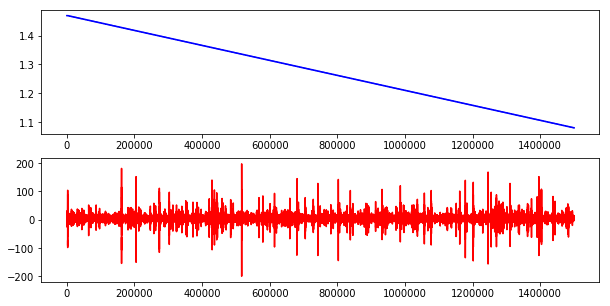

In [3]:
f, ax = plt.subplots(2,1,figsize=(10,5))
ax[0].plot(train.time_to_failure, color='blue')
ax[1].plot(train.acoustic_data,color='red')

In [4]:
test = pd.read_csv('/home/ubuntu/kaggle/LANL_Earthquake/test/seg_00c35b.csv', dtype={'acoustic_data': np.int16})
print(len(test)) #150_000

150000


In [5]:
from sklearn.preprocessing import StandardScaler

In [6]:
#scale train.acoustic_data
def data_scale(train):
    train = train.values
    train_x = np.reshape(train[:,0],(-1,1))
    scaler = StandardScaler()
    scaler.fit(train_x)
    train_x_scaled = scaler.transform(train_x)
    #train['acoustic_data'] = train_x_scaled
    return train_x_scaled

In [7]:
time_series = 150000
step = 100
data_len = 629_145_480
#data_len = 7_845_480

In [8]:
def feature_extraction(train, step=step):
    n = len(train)//step
    m = len(train)%step
    train_x_stat = pd.DataFrame(index = range(n),dtype=np.float64, columns = ['mean','max','min','std','25%','75%'])
    for i in range(n):
        train_x_stat.loc[i,'mean'] = train.acoustic_data[i*step:(i+1)*step].mean()
        train_x_stat.loc[i,'max'] = train.acoustic_data[i*step:(i+1)*step].max()
        train_x_stat.loc[i,'min'] = train.acoustic_data[i*step:(i+1)*step].min()
        train_x_stat.loc[i,'std'] = train.acoustic_data[i*step:(i+1)*step].std()
        train_x_stat.loc[i,'25%'] = np.percentile(train.acoustic_data[i*step:(i+1)*step],25)
        train_x_stat.loc[i,'75%'] = np.percentile(train.acoustic_data[i*step:(i+1)*step],75)

    if m != 0:
        train_x_stat.loc[n,'mean'] = train.acoustic_data[-m:].mean()
        train_x_stat.loc[n,'max'] = train.acoustic_data[-m:].max()
        train_x_stat.loc[n,'min'] = train.acoustic_data[-m:].min()
        train_x_stat.loc[n,'std'] = train.acoustic_data[-m:].std()
        train_x_stat.loc[n,'25%'] = np.percentile(train.acoustic_data[-m:],25)
        train_x_stat.loc[n,'75%'] = np.percentile(train.acoustic_data[-m:],75)
    return train_x_stat

In [9]:
def feature_extraction_vec(train, step=step):
    #n = len(train)//step * step
    #train = train.values
    train = np.reshape(train,(-1, step))
    
    train_x_stat = pd.DataFrame(index = range(len(train)),dtype=np.float64, columns = ['mean','max','min','std','25%','75%'])
    train_x_stat['mean']=np.mean(train, axis=1)
    train_x_stat['max']=np.max(train, axis=1)
    train_x_stat['min']=np.min(train, axis=1)
    train_x_stat['std']=np.std(train, axis=1)
    train_x_stat['25%']=np.percentile(train, q=25, axis=1)
    train_x_stat['75%']=np.percentile(train, q=75, axis=1)
   
    return train_x_stat

In [10]:
def convert_for_nn(train_x_stat, time_series=time_series, step=step):
    train_x_array = train_x_stat.values
    train_x = np.reshape(train_x_array,(-1,int(time_series/step),6))
    return train_x

In [11]:
from keras.models import Sequential
from keras.layers import Conv1D, MaxPooling1D, Dense, GlobalAveragePooling1D, GlobalMaxPooling1D, BatchNormalization, Activation,Flatten,LSTM,CuDNNLSTM
import warnings
warnings.filterwarnings("ignore")

In [12]:
model_conv1D = Sequential()
model_conv1D.add(Conv1D(16,32,strides=1,input_shape = (int(time_series/step),6)))
#model_conv1D.add(BatchNormalization())
model_conv1D.add(Activation('relu'))
#model.add(MaxPooling1D(2))

model_conv1D.add(Conv1D(16,32,strides=1))
#model_conv1D.add(BatchNormalization())
model_conv1D.add(Activation('relu'))
model_conv1D.add(MaxPooling1D(2))

model_conv1D.add(Conv1D(32,16,strides=1))
#model_conv1D.add(BatchNormalization())
model_conv1D.add(Activation('relu'))
#model.add(MaxPooling1D(2))

#model.add(GlobalAveragePooling1D())
model_conv1D.add(Flatten())
model_conv1D.add(Dense(64))
#model_conv1D.add(BatchNormalization())

model_conv1D.add(Dense(32))
model_conv1D.add(Activation('relu'))

model_conv1D.add(Dense(1,activation='linear'))

In [13]:
model_conv1D.summary()

_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv1d_1 (Conv1D)            (None, 1469, 16)          3088      
_________________________________________________________________
activation_1 (Activation)    (None, 1469, 16)          0         
_________________________________________________________________
conv1d_2 (Conv1D)            (None, 1438, 16)          8208      
_________________________________________________________________
activation_2 (Activation)    (None, 1438, 16)          0         
_________________________________________________________________
max_pooling1d_1 (MaxPooling1 (None, 719, 16)           0         
_________________________________________________________________
conv1d_3 (Conv1D)            (None, 704, 32)           8224      
_________________________________________________________________
activation_3 (Activation)    (None, 704, 32)           0         
__________

In [20]:
class MY_Generator(Sequence):

    def __init__(self, file_path, batch_size, step, time_series, val_size):
        self.file_path = file_path
        self.batch_size = batch_size
        self.step = step
        self.time_series = time_series
        self.val_size = val_size
        #self.on_epoch_end()

    def __len__(self):
        return int(np.ceil(data_len / float(self.batch_size/10)))

    def __getitem__(self, idx):
        #print(idx)
        if (idx+1)*self.batch_size + self.val_size < data_len:
            row_nums = list(range(idx*self.batch_size + self.val_size,(idx+1)*self.batch_size + self.val_size))
        else:
            row_nums = list(range(idx*self.batch_size + self.val_size,data_len))
      
        batch_x, batch_y = self.__data_generation(row_nums, idx)
        return batch_x, batch_y

   # def on_epoch_end(self):
    #    print('one epoch starts')
    
    def __data_generation(self, row_nums, idx):
        #print(row_nums[0], row_nums[-1])
        temp = pd.read_csv(self.file_path, dtype={'acoustic_data': np.int16, 'time_to_failure': np.float64}, 
                nrows=len(row_nums), skiprows=range(1,row_nums[0]+1))
        #temp = train[row_nums[0]:row_nums[-1]+1]
        dim = int((len(row_nums)//self.time_series)*self.time_series)
        temp_scaled = data_scale(temp[:dim])
        #print(temp_scaled.shape)
        batch_x_stat = feature_extraction_vec(temp_scaled, step = self.step)
        #print(batch_x_stat.shape)
        #print(dim)
        batch_x = convert_for_nn(batch_x_stat, self.time_series, self.step)
        
        batch_y_tmp = temp.time_to_failure[self.time_series-1::self.time_series]
        train_y_array = batch_y_tmp.values
        batch_y = np.reshape(train_y_array,(-1,1))
        #print('batch'+str(idx)+' done')

        return batch_x, batch_y

In [21]:
batch_size =time_series * 16
val_size = time_series * 20

In [22]:
#preparing validation data set
validation = pd.read_csv('/home/ubuntu/kaggle/LANL_Earthquake/train.csv', dtype={'acoustic_data': np.int16, 'time_to_failure': np.float64}, 
                    nrows=val_size, skiprows=0)
val_scaled = data_scale(validation)
val_x_stat = feature_extraction_vec(val_scaled, step = step)
val_x = convert_for_nn(val_x_stat, time_series, step)
val_y = validation.time_to_failure[time_series-1::time_series]
val_y_array = val_y.values
val_y = np.reshape(val_y_array,(-1,1))
print(val_x.shape, val_y.shape)
val = (val_x, val_y)

(20, 1500, 6) (20, 1)


In [23]:
my_training_batch_generator = MY_Generator('/home/ubuntu/kaggle/LANL_Earthquake/train.csv', batch_size=batch_size, step=step, 
                                           time_series = time_series, val_size = val_size)

model_conv1D.compile(optimizer='adam', loss='mean_squared_error')
history_conv1D = model_conv1D.fit_generator(generator=my_training_batch_generator, 
                                          epochs=1,
                                          steps_per_epoch = int((data_len/10-val_size)/batch_size)-1,
                                          validation_data=val,
                                          use_multiprocessing=True,
                                          shuffle = False,
                                            workers = 6
                                          )

Epoch 1/1
23/23 [==============================] - 90s 4s/step - loss: 30.7803 - val_loss: 29.2652


In [24]:
#preparing mini_training data set
mini_train = pd.read_csv('/home/ubuntu/kaggle/LANL_Earthquake/train.csv', dtype={'acoustic_data': np.int16, 'time_to_failure': np.float64}, 
                    nrows=time_series*100, skiprows=range(1,val_size+1))
mini_train_scaled = data_scale(mini_train)
mini_train_x_stat = feature_extraction_vec(mini_train_scaled, step = step)
mini_train_x = convert_for_nn(mini_train_x_stat, time_series, step)
mini_train_y = mini_train.time_to_failure[time_series-1::time_series]
mini_train_y_array = mini_train_y.values
mini_train_y = np.reshape(mini_train_y_array,(-1,1))
print(mini_train_x.shape, mini_train_y.shape)

(100, 1500, 6) (100, 1)


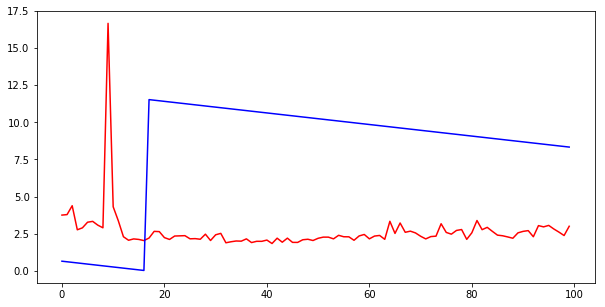

In [25]:
pred_y = model_conv1D.predict(mini_train_x, batch_size=16)
f = plt.figure(figsize=(10,5))
plt.plot(pred_y,color='red')
plt.plot(mini_train_y, color='blue')
plt.show()

In [26]:
model = Sequential()
model.add(Conv1D(8,32,strides=1,activation='relu',input_shape = (1500,6)))
#model.add(BatchNormalization())
model.add(Conv1D(8,32,strides=1,activation='relu',input_shape = (1500,6)))
#model.add(BatchNormalization())
model.add(MaxPooling1D(2))
model.add(Conv1D(16,16,strides=1,activation='relu'))
#model.add(BatchNormalization())
model.add(Conv1D(16,16,strides=1,activation='relu'))
#model.add(BatchNormalization())
model.add(MaxPooling1D(2))
model.add(Conv1D(32,8,strides=1,activation='relu'))
#model.add(BatchNormalization())
model.add(Conv1D(32,8,strides=1,activation='relu'))
model.add(GlobalMaxPooling1D())
model.add(Dense(1, activation=None))

In [27]:
model.summary()

_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv1d_4 (Conv1D)            (None, 1469, 8)           1544      
_________________________________________________________________
conv1d_5 (Conv1D)            (None, 1438, 8)           2056      
_________________________________________________________________
max_pooling1d_2 (MaxPooling1 (None, 719, 8)            0         
_________________________________________________________________
conv1d_6 (Conv1D)            (None, 704, 16)           2064      
_________________________________________________________________
conv1d_7 (Conv1D)            (None, 689, 16)           4112      
_________________________________________________________________
max_pooling1d_3 (MaxPooling1 (None, 344, 16)           0         
_________________________________________________________________
conv1d_8 (Conv1D)            (None, 337, 32)           4128      
__________

In [28]:
my_training_batch_generator = MY_Generator('/home/ubuntu/kaggle/LANL_Earthquake/train.csv', batch_size=batch_size, step=step, 
                                           time_series = time_series, val_size = val_size)

model.compile(optimizer='adam', loss='mean_squared_error')
history_conv1D = model.fit_generator(generator=my_training_batch_generator, 
                                          epochs=1,
                                          steps_per_epoch = int((data_len/10-val_size)/batch_size)-1,
                                          validation_data=val,
                                          use_multiprocessing=True,
                                          shuffle = False,
                                            workers = 6)

Epoch 1/1
23/23 [==============================] - 102s 4s/step - loss: 43.3363 - val_loss: 0.3394


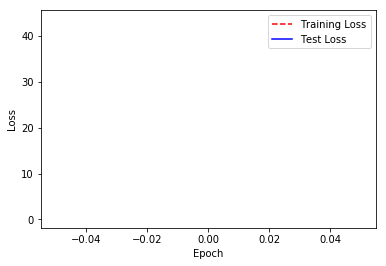

In [30]:
plt.plot(history_conv1D.history['loss'], 'r--')
plt.plot(history_conv1D.history['val_loss'], 'b-')
plt.legend(['Training Loss', 'Test Loss'])
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.show();

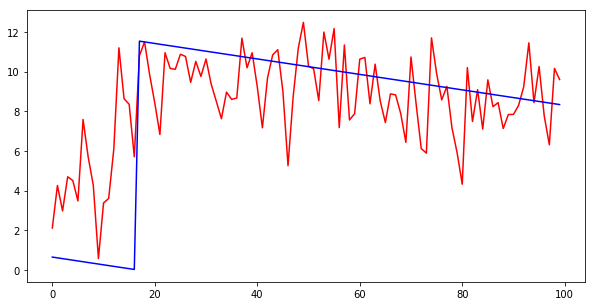

In [105]:
pred_y = model.predict(mini_train_x, batch_size=16)
f = plt.figure(figsize=(10,5))
plt.plot(pred_y,color='red')
plt.plot(mini_train_y, color='blue')
plt.show()

In [31]:
model_lstm = Sequential()
model_lstm.add(CuDNNLSTM(32, return_sequences=True, input_shape=(time_series/step,6)))
model_lstm.add(CuDNNLSTM(64, return_sequences=True))
model_lstm.add(CuDNNLSTM(128, return_sequences=False))
#model.add(Dropout(0.5))
#model.add(BatchNormalization())
model_lstm.add(Dense(128, activation='relu'))
model_lstm.add(Dense(256, activation='relu'))
model_lstm.add(Dense(1, activation='linear'))

In [32]:
model_lstm.summary()

_________________________________________________________________
Layer (type)                 Output Shape              Param #   
cu_dnnlstm_1 (CuDNNLSTM)     (None, 1500.0, 32)        5120      
_________________________________________________________________
cu_dnnlstm_2 (CuDNNLSTM)     (None, 1500.0, 64)        25088     
_________________________________________________________________
cu_dnnlstm_3 (CuDNNLSTM)     (None, 128)               99328     
_________________________________________________________________
dense_5 (Dense)              (None, 128)               16512     
_________________________________________________________________
dense_6 (Dense)              (None, 256)               33024     
_________________________________________________________________
dense_7 (Dense)              (None, 1)                 257       
Total params: 179,329
Trainable params: 179,329
Non-trainable params: 0
_________________________________________________________________


In [36]:
my_training_batch_generator = MY_Generator('/home/ubuntu/kaggle/LANL_Earthquake/train.csv', batch_size=batch_size, step=step, 
                                           time_series = time_series, val_size = val_size)

model_lstm.compile(optimizer='adam', loss='mean_squared_error')
history_conv1D = model_lstm.fit_generator(generator=my_training_batch_generator, 
                                          epochs=1,
                                          steps_per_epoch = int((data_len/10-val_size)/batch_size)-1,
                                          validation_data=val,
                                          use_multiprocessing=True,
                                          shuffle = False,
                                            workers = 6)

Epoch 1/1
23/23 [==============================] - 137s 6s/step - loss: 30.7087 - val_loss: 8.7741


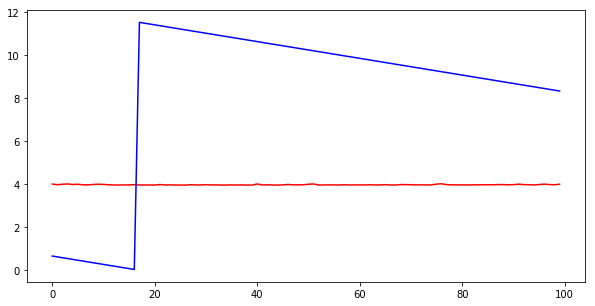

In [37]:
pred_y = model_lstm.predict(mini_train_x, batch_size=16)
f = plt.figure(figsize=(10,5))
plt.plot(pred_y,color='red')
plt.plot(mini_train_y, color='blue')
plt.show()

In [38]:
tests = os.listdir("/home/ubuntu/kaggle/LANL_Earthquake/test/")
tests.sort()

In [39]:
len(tests) #2624

2624

In [26]:
import tqdm

In [ ]:
#making submission file using conv1D
sub_conv1D = pd.DataFrame(index = range(len(tests)),dtype=np.float64, columns = ['seg_id','time_to_failure'])

for i, test in enumerate(tqdm.tqdm(tests)):
    test_f = pd.read_csv('/home/ubuntu/kaggle/LANL_Earthquake/test/' + test)
    tmp = data_scale(test_f)
    tmp2 = feature_extraction_vec(tmp)
    test_X = convert_for_nn(tmp2)
    test_pred = np.float(model_conv1D.predict(test_X))
    sub_conv1D.loc[i,'seg_id'] = str(test).split('.')[0]
    sub_conv1D.loc[i,'time_to_failure']= test_pred
sub_conv1D.to_csv('conv1D_submission.csv', index=False)

In [ ]:
#making submission file using model
sub_model = pd.DataFrame(index = range(len(tests)),dtype=np.float64, columns = ['seg_id','time_to_failure'])

for i, test in enumerate(tqdm.tqdm(tests[:2])):
    test_f = pd.read_csv('/home/ubuntu/kaggle/LANL_Earthquake/test/' + test)
    tmp = data_scale(test_f)
    tmp2 = feature_extraction_vec(tmp)
    test_X = convert_for_nn(tmp2)
    test_pred = np.float(model.predict(test_X))
    sub_model.loc[i,'seg_id'] = str(test).split('.')[0]
    sub_model.loc[i,'time_to_failure']= test_pred
sub_model.to_csv('model_submission.csv', index=False)

In [ ]:
sub_model.head()

In [ ]:
#making submission file using LSTM
sub_lstm = pd.DataFrame(index = range(len(tests)),dtype=np.float64, columns = ['seg_id','time_to_failure'])

for i, test in enumerate(tqdm.tqdm(tests)):
    test_f = pd.read_csv('/home/ubuntu/kaggle/LANL_Earthquake/test/' + test)
    tmp = data_scale(test_f)
    tmp2 = feature_extraction_vec(tmp)
    test_X = convert_for_nn(tmp2)
    test_pred = np.float(model_lstm.predict(test_X))
    sub_lstm.loc[i,'seg_id'] = str(test).split('.')[0]
    sub_lstm.loc[i,'time_to_failure']= test_pred
sub_lstm.to_csv('lstm_submission.csv', index=False)